In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from globalVariables import *
import simpleCNNwithInception as inceptionCNN
import simpleCNN as simpleCNN
import simpleCNNwithInceptionRegression as regressor
from keras.callbacks import CSVLogger
from scipy.ndimage import rotate
import glob as glob
from getSIDMdata_generator import get_tf_DataSet as getGenerators
import scienceplots
plt.style.use(["science", "grid"])

Objectives
----------
1. To see if adding channels increases the accuracy of the model
2. To see if adding correlation functions between models increases the accuracy of the model

Conclusions
-----------



#### 1. Get the fiducial

In [ ]:
data_files = glob.glob("pickles/allSim*")
histories = []
epochs=80
simulationNames = ['CDM','SIDM0.1','SIDM1']
nClasses = len(simulationNames)
for iFile in data_files:
    if 'mean' in iFile:
        continue
    
    train, test  = getGenerators(augment_data=True, simulationNames=simulationNames,channels=['total','stellar','xray'],
                                                      allDataFile=iFile)
    
    model = simpleCNN.getModel_ds(nClasses)

    au_history = model.fit(
      x=train,
        validation_data=test,
      epochs=epochs
    )
    histories.append( au_history.history )
                                 
pkl.dump(histories, open("pickles/test_data_sensitivity.pkl","wb"))

#### Results

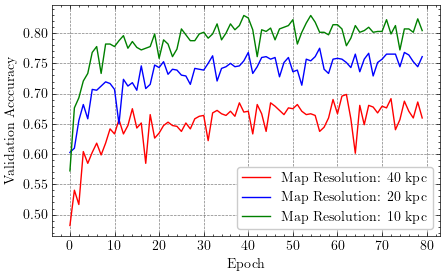

In [11]:
plt.figure(figsize=(5,3))
plt.xlabel('Epoch')
plt.ylabel('Validation Acccuracy')
models = pkl.load(open("pickles/test_data_sensitivity.pkl","rb"))

c = ['r','b','g','c','y','k']
names = [ i.split('_')[-1].split('.')[0] for i in data_files]

for i, iModel in enumerate(models):
    plt.plot(np.arange(len(iModel['val_accuracy'])), iModel['val_accuracy'], label="Map Resolution: %s kpc" %names[i], c=c[i])
    #plt.plot(iModel.history.epoch, [np.max(iModel.history.history['val_accuracy'])]*len(iModel.history.epoch), c=c[i])
    #print(np.max(iModel.history.history['val_accuracy']))

plt.legend()
plt.savefig("../plots/data_sensitivty.pdf")

#### So trying adding channels simply with a model per channel

In [ ]:
(train_images, train_att, train_labels), testSets = \
        getData(  indexFileRoot='pickles/testIndexes', testTrainSplit=0.15, nChannels=2)

test_labels, test_images, test_att = None, None, None
for i in testSets.keys():
    if test_labels is None:
        test_images = testSets[i]['images']
        test_labels = testSets[i]['labels']
    else:
        test_labels = np.vstack((test_labels, testSets[i]['labels']))
        test_images = np.vstack((test_images, testSets[i]['images']))
        
nClasses = len(np.unique(train_labels))
inputShape = train_images.shape[1:]
nAttributes = train_att.shape[1]

color=['r','g','b','c']

#Test the momentum on reliability

csv_file = 'pickles/addAttributesAddChannelWithModel_SGD.csv'
csv_logger = CSVLogger(csv_file, append=True)
model_file =  'pickles/addAttributesAddChannelWithModel_SGD.h5'
    
if os.path.isfile( csv_file ):
    previousEpochs = np.loadtxt( csv_file, delimiter=',',skiprows=1 )
    initial_epoch = previousEpochs.shape[0]
else:
    initial_epoch = 0
        
if os.path.isfile(model_file):
    print("FOUND PREVIOUS MODEL, LOADING...")
    model = models.load_model(model_file)
else:
    model = simpleCNN.getModelSeparateChannels( inputShape, nClasses, nAttributes=0, \
                               momentum=0.9, finalLayer=256, learning_rate=1e-4)
    
nChannels = train_images.shape[-1]
inputLayer = [ train_images[:,:,:,i][:,:,:,np.newaxis] for i in range(nChannels)]
testInputLayer = [ test_images[:,:,:,i][:,:,:,np.newaxis] for i in range(nChannels)]


history = model.fit(inputLayer, train_labels, epochs=40, 
                    initial_epoch=0,
                    validation_data=(testInputLayer, test_labels),
                       callbacks=csv_logger)
model.save(model_file)



In [ ]:
train_images.shape

In [ ]:
(train_images, train_att, train_labels), testSets = \
        getData(  indexFileRoot='pickles/testIndexes', testTrainSplit=0.15, nChannels=2)

test_labels, test_images, test_att = None, None, None
for i in testSets.keys():
    if test_labels is None:
        test_images = testSets[i]['images']
        test_labels = testSets[i]['labels']
    else:
        test_labels = np.vstack((test_labels, testSets[i]['labels']))
        test_images = np.vstack((test_images, testSets[i]['images']))
        
nClasses = len(np.unique(train_labels))
inputShape = train_images.shape[1:]
nAttributes = train_att.shape[1]


color=['r','g','b','c']

#Test the momentum on reliability

csv_file = 'pickles/addAttributesAddChannel_SGD.csv'
csv_logger = CSVLogger(csv_file, append=True)
model_file =  'pickles/addAttributesAddChannel_SGD.h5'
    
if os.path.isfile( csv_file ):
    previousEpochs = np.loadtxt( csv_file, delimiter=',',skiprows=1 )
    initial_epoch = previousEpochs.shape[0]
else:
    initial_epoch = 0
        
if os.path.isfile(model_file):
    print("FOUND PREVIOUS MODEL, LOADING...")
    model = models.load_model(model_file)
else:
    model = simpleCNN.getModel( inputShape, nClasses, nAttributes=0, \
                               momentum=0.9, finalLayer=256, learning_rate=1e-4)
    
nChannels = train_images.shape[-1]


history = model.fit(train_images, train_labels, epochs=40, 
                    initial_epoch=0,
                    validation_data=(test_images, test_labels),
                       callbacks=csv_logger)
model.save(model_file)



In [ ]:
(train_images, train_att, train_labels), testSets = \
        getData(  indexFileRoot='pickles/testIndexes', testTrainSplit=0.15, nChannels=3)

test_labels, test_images, test_att = None, None, None
for i in testSets.keys():
    if test_labels is None:
        test_images = testSets[i]['images']
        test_labels = testSets[i]['labels']
    else:
        test_labels = np.vstack((test_labels, testSets[i]['labels']))
        test_images = np.vstack((test_images, testSets[i]['images']))
        


color=['r','g','b','c']

train_images[:, :, :, 1] =  train_images[:,:,:,2]
train_images = train_images[:, :, :, :2]


test_images[:, :, :, 1] =  test_images[:,:,:,2]
test_images = test_images[:, :, :, :2]

nClasses = len(np.unique(train_labels))
inputShape = train_images.shape[1:]
nAttributes = train_att.shape[1]

#Test the momentum on reliability

csv_file = 'pickles/addAttributesAddChannelStellar_SGD.csv'
csv_logger = CSVLogger(csv_file, append=True)
model_file =  'pickles/addAttributesAddChannelStellar_SGD.h5'
    
if os.path.isfile( csv_file ):
    previousEpochs = np.loadtxt( csv_file, delimiter=',',skiprows=1 )
    initial_epoch = previousEpochs.shape[0]
else:
    initial_epoch = 0
        
if os.path.isfile(model_file):
    print("FOUND PREVIOUS MODEL, LOADING...")
    model = models.load_model(model_file)
else:
    model = simpleCNN.getModel( inputShape, nClasses, nAttributes=0, \
                               momentum=0.9, finalLayer=256, learning_rate=1e-4)
    
nChannels = train_images.shape[-1]


history = model.fit(train_images, train_labels, epochs=40, 
                    initial_epoch=0,
                    validation_data=(test_images, test_labels),
                       callbacks=csv_logger)
model.save(model_file)



In [ ]:
(train_images, train_att, train_labels), testSets = \
        getData(  indexFileRoot='pickles/testIndexes', testTrainSplit=0.15, nChannels=3)

test_labels, test_images, test_att = None, None, None
for i in testSets.keys():
    if test_labels is None:
        test_images = testSets[i]['images']
        test_labels = testSets[i]['labels']
    else:
        test_labels = np.vstack((test_labels, testSets[i]['labels']))
        test_images = np.vstack((test_images, testSets[i]['images']))
        


color=['r','g','b','c']

nClasses = len(np.unique(train_labels))
inputShape = train_images.shape[1:]
nAttributes = train_att.shape[1]

#Test the momentum on reliability

csv_file = 'pickles/addAttributesAddChannelAll_SGD.csv'
csv_logger = CSVLogger(csv_file, append=True)
model_file =  'pickles/addAttributesAddChannelAll_SGD.h5'
    
if os.path.isfile( csv_file ):
    previousEpochs = np.loadtxt( csv_file, delimiter=',',skiprows=1 )
    initial_epoch = previousEpochs.shape[0]
else:
    initial_epoch = 0
        
if os.path.isfile(model_file):
    print("FOUND PREVIOUS MODEL, LOADING...")
    model = models.load_model(model_file)
else:
    model = simpleCNN.getModel( inputShape, nClasses, nAttributes=0, \
                               momentum=0.9, finalLayer=256, learning_rate=1e-4)
    
nChannels = train_images.shape[-1]


history = model.fit(train_images, train_labels, epochs=40, 
                    initial_epoch=0,
                    validation_data=(test_images, test_labels),
                       callbacks=csv_logger)
model.save(model_file)



In [ ]:
(train_images, train_att, train_labels), testSets = \
        getData(  indexFileRoot='pickles/testIndexes', testTrainSplit=0.15, nChannels=2)

test_labels, test_images, test_att = None, None, None
for i in testSets.keys():
    if test_labels is None:
        test_images = testSets[i]['images']
        test_labels = testSets[i]['labels']
    else:
        test_labels = np.vstack((test_labels, testSets[i]['labels']))
        test_images = np.vstack((test_images, testSets[i]['images']))
        


color=['r','g','b','c']

nClasses = len(np.unique(train_labels))
inputShape = train_images.shape[1:]
nAttributes = train_att.shape[1]

#Test the momentum on reliability

csv_file = 'pickles/addAttributesAddChannelDepthWise_2_SGD.csv'
csv_logger = CSVLogger(csv_file, append=True)
model_file =  'pickles/addAttributesAddChannelDepthWise_2_SGD.h5'
    
if os.path.isfile( csv_file ):
    previousEpochs = np.loadtxt( csv_file, delimiter=',',skiprows=1 )
    initial_epoch = previousEpochs.shape[0]
else:
    initial_epoch = 0
        
if os.path.isfile(model_file):
    print("FOUND PREVIOUS MODEL, LOADING...")
    model = models.load_model(model_file)
else:
    model = simpleCNN.getDepthWiseConvolution( inputShape, nClasses, nAttributes=0, \
                              momentum=0.9, finalLayer=256, learning_rate=1e-4)
model.summary()

nChannels = train_images.shape[-1]


history = model.fit(train_images, train_labels, epochs=40, 
                    initial_epoch=0,
                    validation_data=(test_images, test_labels),
                       callbacks=csv_logger)
model.save(model_file)

